In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import inf
from optical_flow import *
from tqdm import tqdm

seq_path = '../datasets/results_opticalflow_kitti/'

In [8]:
past_img = cv2.imread(seq_path + '000045_10.png')
current_img = cv2.imread(seq_path + '000045_11.png')

optical_flow_path = seq_path +'gt_000045_10_noc.png'
gt_flow = load_flow(optical_flow_path)

In [16]:
def distance(patch1, patch2, method='ssd', weights=None):
    # if weights is None:
    #     weights = np.ones(patch1.shape) / (patch1.shape[0]*patch1.shape[1])
    if method == 'ssd':
        diff = (patch1-patch2)**2
    if method == 'sad':
        diff = np.abs(patch1-patch2)
    return np.sum(diff)

In [20]:
N = 41 # block size
P = N # Search area
areaSize = 2 * P + N
h, w = past_img.shape[:2]

# from sklearn.feature_extraction import image
# blocks = image.extract_patches_2d(past_img, (N, N), max_patches=(int(past_img.shape[0]/N)**2))

optical_flow = np.zeros((h, w, 2))

for rows in tqdm(range(0, h - N, N)):
    for cols in range(0, w - N, N):
        block = past_img[rows:rows+N,cols:cols+N]
        area_minx = max(0, cols - P)
        area_miny = max(0, rows - P)
        area_maxX = min(w - N, cols + P)
        area_maxy = min(h - N, rows + P)
        # area_target = past_img[area_miny:area_maxy, area_minx:area_maxX]
        blocH_size = block.shape[0]
        blocW_size = block.shape[1]
        minDist = inf
        for y in range(area_miny,area_maxy):
            for x in range(area_minx,area_maxX):
                dist = distance(block, current_img[y:y+blocH_size, x:x+blocW_size])
                if dist < minDist:
                    minDist = dist
                    optical_flow[rows:rows+N,cols:cols+N] = [cols - x, rows - y]


100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


In [21]:
optical_flow = np.moveaxis(optical_flow, -1, 0)

MSNE:  9.387904991476162 PEPN: 33.95763442921499


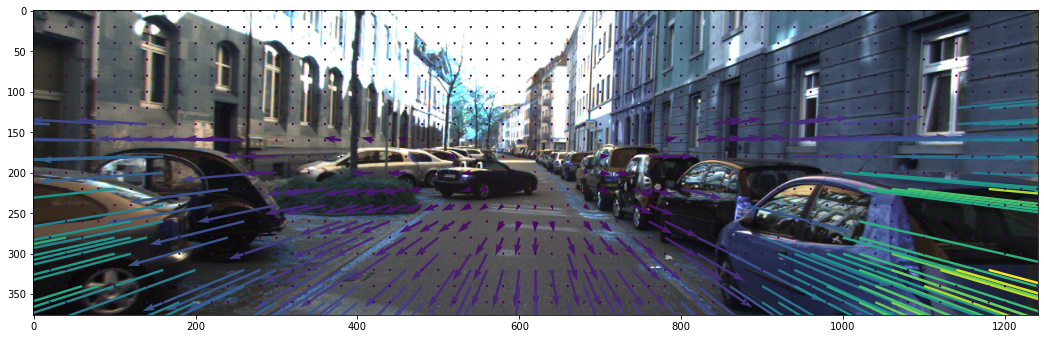

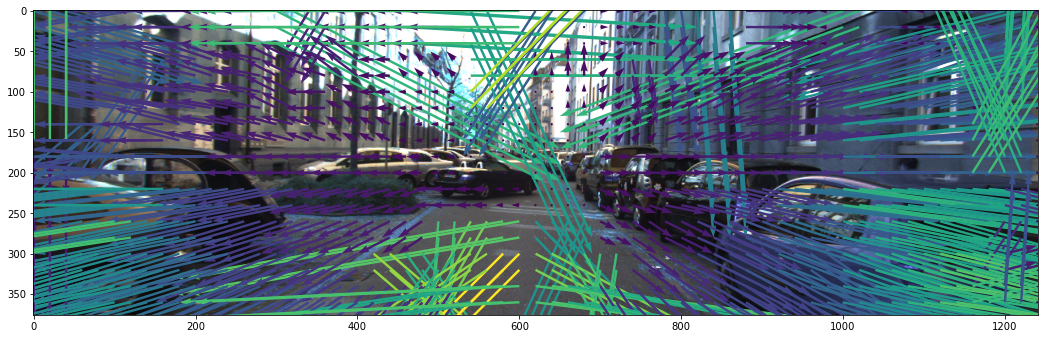

In [22]:
error_msne = flow_msen(gt_flow, -optical_flow)
error_pepn = flow_pepn(gt_flow, -optical_flow)
print('MSNE: ', error_msne, 'PEPN:', error_pepn)
plot_optical_flow_field(seq_path + '000045_11.png', gt_flow)
plot_optical_flow_field(seq_path + '000045_11.png', -optical_flow)